<a href="https://colab.research.google.com/github/Yanina-Kutovaya/fraud-detection/blob/main/notebooks/Baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
APP_NAME = 'MLFlow Baseline model'
YC_INPUT_DATA_BUCKET = 'airflow-cc-input'
YC_SOURCE_BUCKET = 'airflow-cc-source'

In [2]:
#!pip install pyspark
#!pip install mlflow

In [3]:
import requests

CUSTOM_TRANSFORMERS_URL = f'https://storage.yandexcloud.net/{YC_SOURCE_BUCKET}/custom_transformers.py'
FEATURE_EXTRACTION_PIPELINE_URL = f'https://storage.yandexcloud.net/{YC_SOURCE_BUCKET}/feature_extraction_pipeline.py'

r = requests.get(CUSTOM_TRANSFORMERS_URL, allow_redirects=True)
open('custom_transformers.py', 'wb').write(r.content)

r = requests.get(FEATURE_EXTRACTION_PIPELINE_URL, allow_redirects=True)
open('feature_extraction_pipeline.py', 'wb').write(r.content)

3727

In [4]:
import pandas as pd
import numpy as np
import logging
import easydict
import argparse
from datetime import datetime
from pyspark import SparkFiles
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DoubleType

import mlflow
from mlflow.tracking import MlflowClient
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier

from scipy.stats import norm, ttest_ind
import seaborn as sns

from custom_transformers import (
    DiscreteToBinaryTransformer,
    ContinuousOutliersCapper,
    TimeFeaturesGenerator,
    ScalarNAFiller,
    StringFromDiscrete
)
from feature_extraction_pipeline import get_feature_extraction_pipeline

In [5]:
logging.basicConfig(level=logging.INFO, format="%(asctime)-15s %(message)s")
logger = logging.getLogger()

In [6]:
def train_validation_split(data):
  t = 3600 * 24 * 30
  train = data.filter(F.col('TransactionDT') < t)
  compromised_cards = (
      train['card1', 'isFraud'].filter(F.col('isFraud') == 1)
      .groupBy('card1').count().toPandas()['card1'].tolist()
  )           
  valid = (
      data.filter(F.col('TransactionDT') >= t)
      .where(~F.col('card1').isin(compromised_cards))
  )
  return train, valid


def get_cards_precision_top_k(
    predictions, k=50, plot=True, 
    bootstrap_iterations=100, seed=25):
  np.random.seed(seed)
  scores = pd.DataFrame(
      data={f'precision_top_{k}': 0.0}, 
      index=range(bootstrap_iterations)
  )
  def extract_prob(v):
    try:
        return float(v[1])  
    except ValueError:
        return None

  extract_prob_udf = F.udf(extract_prob, DoubleType())
  predictions = predictions.withColumn(
      'prob_flag', extract_prob_udf(F.col('probability'))
  )
  df = (
    predictions.select('card1', 'prob_flag', 'isFraud')
    .groupBy('card1').max('prob_flag', 'isFraud')
    .orderBy(F.col('max(prob_flag)').desc())
    .select('max(isFraud)')
    .limit(k)        
    .toPandas()    
  )
  for i in range(bootstrap_iterations):
      sample = df.sample(frac=1.0, replace=True)
      scores.loc[i, f'precision_top_{k}'] = sample.sum()[0] / k

  precision_mean = scores[f'precision_top_{k}'].mean()
  precision_std = scores[f'precision_top_{k}'].std()
  precision_low = precision_mean - 3 * precision_std
  precision_upp = precision_mean + 3 * precision_std

  if plot:
      print(f'CP@{k} = {round(precision_mean, 4)} +/- {round(precision_std, 4)}\n')
      ax = sns.kdeplot(x=scores[f'precision_top_{k}'])
      x = np.linspace(precision_low, precision_upp, bootstrap_iterations)
      y = norm.pdf(x, loc=precision_mean, scale=precision_std)
      ax.plot(x, y, color="red");

  return precision_mean, precision_std

In [7]:
def main(args):
  logger.info('Creating Spark Session ...')
  spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

  logger.info('Loading data ...')
  spark.sparkContext.addFile(args.train_data_URL)
  data = spark.read.parquet(
      SparkFiles.get(args.train_artifact), header=True, inferSchema=True
  )

  logger.info('Train validation split ...')
  train, valid = train_validation_split(data)

  # Prepare MLflow experiment for logging
  client = MlflowClient()
  experiment_id = client.create_experiment(args.output_artifact)
  # Set run_name for search in mlflow 
  run_name = f'Credit_cards_fraud_detection_pipline {str(datetime.now())}' 
  with mlflow.start_run(run_name=run_name, experiment_id=experiment_id):
    logger.info("Building an inference pipeline ...")
    feature_extraction_pipeline = get_feature_extraction_pipeline()
    stages = feature_extraction_pipeline.getStages()
    classifier = GBTClassifier(
            featuresCol='features',
            labelCol='isFraud',
            maxDepth = 6,
            minInstancesPerNode=1000
    )
    stages.append(classifier)
    inference_pipeline = Pipeline(stages=stages)

    logger.info("Fitting an inference pipeline ...")
    model = inference_pipeline.fit(train)

    # Log params, metrics and model with MLFlow
    run_id = mlflow.active_run().info.run_id
    logger.info(f"Logging parameters to MLflow run {run_id} ...")

    maxDepth = model.stages[-1].getMaxDepth() 
    minInstancesPerNode = model.stages[-1].getMinInstancesPerNode()    

    logger.info(model.stages[-1].explainParam('maxDepth'))       
    logger.info(model.stages[-1].explainParam('minInstancesPerNode')) 

    mlflow.log_param('maxDepth', maxDepth)
    mlflow.log_param('minInstancesPerNode', minInstancesPerNode)

    logger.info('Scoring the model ...')  
    predictions = model.transform(valid) 
    precision_mean, precision_std = get_cards_precision_top_k(predictions, args.k, True)

    logger.info(f'Logging metrics to MLflow run {run_id} ...')     
    mlflow.log_metric(f'CP_at_{args.k}_mean', precision_mean)
    mlflow.log_metric(f'CP_at_{args.k}_std', precision_std)
    logger.info(f'Model CP@50: {round(precision_mean, 4)} +/- {round(precision_std, 4)}')

    logger.info("Saving pipeline ...")
    mlflow.spark.save_model(model, args.output_artifact)

    logger.info("Exporting/logging pipline ...")
    mlflow.spark.log_model(model, args.output_artifact)  

    logger.info('Done')

  spark.stop()

CP@50 = 0.1186 +/- 0.0402



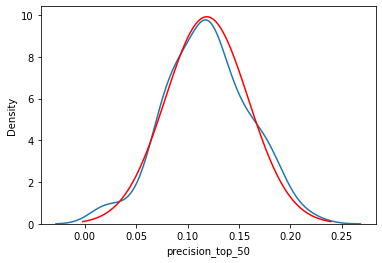

In [8]:
args = easydict.EasyDict(
    {
        'train_data_URL': 'https://storage.yandexcloud.net/credit-cards-data/train.parquet',
        'train_artifact': 'train.parquet',             
        'output_artifact': 'Spark_GBTClassifier_v1',
        'k': 50
    }
)

main(args)